In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, AutoConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seeds(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# ====================================================================
# 1. DATA PREPARATION
# ====================================================================

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }
        
def load_imdb_dataset(n_samples=2000):
    """
    Load IMDb movie review dataset
    """
    # Load the IMDb dataset
    dataset = load_dataset("imdb")
    
    # Combine train and test for our active learning experiment
    all_texts = dataset['train']['text'] + dataset['test']['text']
    all_labels = dataset['train']['label'] + dataset['test']['label']
    
    # Sample n_samples if dataset is larger
    if len(all_texts) > n_samples:
        indices = random.sample(range(len(all_texts)), n_samples)
        texts = [all_texts[i] for i in indices]
        labels = [all_labels[i] for i in indices]
    else:
        texts, labels = all_texts, all_labels
    
    print(f"✓ Successfully loaded IMDb dataset")
    return texts, labels

In [14]:
# Load and prepare data
print("Loading IMDb dataset...")
texts, labels = load_imdb_dataset(n_samples=10000)
print(f"Dataset size: {len(texts)} samples")
print(f"Label distribution: {pd.Series(labels).value_counts().to_dict()}")

# Show sample reviews
print("\\nSample reviews:")
for i in range(2):
    label_text = "Positive" if labels[i] == 1 else "Negative"
    print(f"{i+1}. [{label_text}] {texts[i][:100]}...")


# Split into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train size: {len(train_texts)}")
print(f"Test size: {len(test_texts)}")

Loading IMDb dataset...
Loading IMDb dataset from Hugging Face...
✓ Successfully loaded IMDb dataset
Dataset size: 10000 samples
Label distribution: {0: 5059, 1: 4941}
\nSample reviews:
1. [Positive] Though this is a good, enjoyable cartoon, they did much better ones later on, like Carrotblanca. Thi...
2. [Positive] This an free adaptation of the novels of Clarence Mulford; fans of the Willaim Boyd films will proba...
Train size: 8000
Test size: 2000


In [15]:
class BERTClassifier(nn.Module):
    def __init__(self, model_name='bert-base-uncased', num_classes=2, dropout=0.1):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask, return_hidden=False):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        if return_hidden:
            return logits, pooled_output
        return logits

def train_model(model, train_loader, val_loader, epochs=3, lr=2e-5):
    """Train BERT classifier"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    best_val_acc = 0
    
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Validation
        val_acc = evaluate_model(model, val_loader)
        print(f'Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}, Val Acc = {val_acc:.4f}')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model

def evaluate_model(model, data_loader):
    """Evaluate model performance"""
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return accuracy_score(true_labels, predictions)

In [16]:
# ====================================================================
# 3. ACTIVE LEARNING STRATEGIES
# ====================================================================

class ActiveLearner:
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
    
    def uncertainty_sampling(self, unlabeled_texts, n_samples=50, method='entropy'):
        """
        Uncertainty-based query strategy for BERT
        """
        self.model.eval()
        uncertainties = []
        
        # Create dataset and dataloader for unlabeled data
        unlabeled_dataset = TextDataset(
            unlabeled_texts, 
            [0] * len(unlabeled_texts),  # dummy labels
            self.tokenizer
        )
        unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)
        
        with torch.no_grad():
            for batch in unlabeled_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                
                logits = self.model(input_ids, attention_mask)
                probs = torch.softmax(logits, dim=1)
                
                if method == 'entropy':
                    # Calculate entropy
                    entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
                    uncertainties.extend(entropy.cpu().numpy())
                
                elif method == 'least_confidence':
                    # Least confidence sampling
                    max_probs = torch.max(probs, dim=1)[0]
                    confidence = 1 - max_probs
                    uncertainties.extend(confidence.cpu().numpy())
        
        # Select most uncertain samples
        uncertain_indices = np.argsort(uncertainties)[-n_samples:]
        return uncertain_indices
    
    # def dropout_uncertainty(self, unlabeled_texts, n_samples=50, n_forward_passes=10):
    #     """
    #     Monte Carlo Dropout for uncertainty estimation
    #     """
    #     self.model.train()  # Keep dropout active
    #     all_predictions = []
        
    #     unlabeled_dataset = TextDataset(
    #         unlabeled_texts, 
    #         [0] * len(unlabeled_texts),
    #         self.tokenizer
    #     )
    #     unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)
        
    #     # Multiple forward passes with dropout
    #     for _ in range(n_forward_passes):
    #         predictions = []
    #         with torch.no_grad():
    #             for batch in unlabeled_loader:
    #                 input_ids = batch['input_ids'].to(self.device)
    #                 attention_mask = batch['attention_mask'].to(self.device)
                    
    #                 logits = self.model(input_ids, attention_mask)
    #                 probs = torch.softmax(logits, dim=1)
    #                 predictions.append(probs.cpu().numpy())
            
    #         all_predictions.append(np.vstack(predictions))
        
    #     # Calculate uncertainty as variance across predictions
    #     all_predictions = np.array(all_predictions)  # shape: (n_passes, n_samples, n_classes)
    #     variance = np.var(all_predictions, axis=0)  # variance across forward passes
    #     uncertainty = np.mean(variance, axis=1)  # mean variance across classes
        
    #     # Select most uncertain samples
    #     uncertain_indices = np.argsort(uncertainty)[-n_samples:]
    #     self.model.eval()  # Back to eval mode
    #     return uncertain_indices


In [17]:
# ====================================================================
# 4. ACTIVE LEARNING PIPELINE
# ====================================================================

def active_learning_pipeline(train_texts, train_labels, test_texts, test_labels, 
                           initial_pool_size=100, query_size=50, max_iterations=10):
    """
    Complete Active Learning Pipeline with BERT
    """
    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = BERTClassifier().to(device)
    active_learner = ActiveLearner(model, tokenizer, device)
    
    # Prepare test dataset
    test_dataset = TextDataset(test_texts, test_labels, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Initialize pools
    indices = list(range(len(train_texts)))
    random.shuffle(indices)
    
    labeled_indices = indices[:initial_pool_size]
    unlabeled_indices = indices[initial_pool_size:]
    
    results = {
        'iteration': [],
        'labeled_size': [],
        'accuracy': [],
        'f1_score': [],
        'query_strategy': []
    }
    
    print(f"Starting Active Learning with {initial_pool_size} initial samples...")
    
    for iteration in range(max_iterations):
        print(f"\n--- Iteration {iteration + 1} ---")
        print(f"Labeled pool size: {len(labeled_indices)}")
        print(f"Unlabeled pool size: {len(unlabeled_indices)}")
        
        # Prepare current labeled data
        current_texts = [train_texts[i] for i in labeled_indices]
        current_labels = [train_labels[i] for i in labeled_indices]
        
        # Create datasets and loaders
        labeled_dataset = TextDataset(current_texts, current_labels, tokenizer)
        train_loader = DataLoader(labeled_dataset, batch_size=16, shuffle=True)
        
        # Train model on current labeled data
        model = BERTClassifier().to(device)  # Reinitialize for each iteration
        model = train_model(model, train_loader, test_loader, epochs=3)
        
        # Evaluate on test set
        test_accuracy = evaluate_model(model, test_loader)
        
        # Calculate F1 score
        model.eval()
        predictions, true_labels = [], []
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                logits = model(input_ids, attention_mask)
                preds = torch.argmax(logits, dim=1)
                
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        f1 = f1_score(true_labels, predictions, average='weighted')
        
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1 Score: {f1:.4f}")
        
        # Store results
        results['iteration'].append(iteration + 1)
        results['labeled_size'].append(len(labeled_indices))
        results['accuracy'].append(test_accuracy)
        results['f1_score'].append(f1)
        results['query_strategy'].append('entropy')
        
        # Query new samples (if not last iteration)
        if iteration < max_iterations - 1 and len(unlabeled_indices) > 0:
            unlabeled_texts = [train_texts[i] for i in unlabeled_indices]
            
            # Use uncertainty sampling
            query_indices = active_learner.uncertainty_sampling(
                unlabeled_texts, 
                n_samples=min(query_size, len(unlabeled_indices))
            )
            
            # Move queried samples to labeled pool
            selected_indices = [unlabeled_indices[i] for i in query_indices]
            labeled_indices.extend(selected_indices)
            
            # Remove from unlabeled pool
            unlabeled_indices = [idx for i, idx in enumerate(unlabeled_indices) 
                               if i not in query_indices]
    
    return results, model

Starting BERT Active Learning Experiment...
Starting Active Learning with 100 initial samples...

--- Iteration 1 ---
Labeled pool size: 100
Unlabeled pool size: 7900


Epoch 1/3: 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


Epoch 1: Loss = 0.6816, Val Acc = 0.4940


Epoch 2/3: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


Epoch 2: Loss = 0.7131, Val Acc = 0.4940


Epoch 3/3: 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


Epoch 3: Loss = 0.5901, Val Acc = 0.6385
Test Accuracy: 0.6385
Test F1 Score: 0.6094

--- Iteration 2 ---
Labeled pool size: 150
Unlabeled pool size: 7850


Epoch 1/3: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Epoch 1: Loss = 0.7013, Val Acc = 0.6130


Epoch 2/3: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Epoch 2: Loss = 0.6394, Val Acc = 0.6180


Epoch 3/3: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Epoch 3: Loss = 0.5514, Val Acc = 0.6760
Test Accuracy: 0.6760
Test F1 Score: 0.6475

--- Iteration 3 ---
Labeled pool size: 200
Unlabeled pool size: 7800


Epoch 1/3: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


Epoch 1: Loss = 0.7155, Val Acc = 0.5440


Epoch 2/3: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


Epoch 2: Loss = 0.6257, Val Acc = 0.6750


Epoch 3/3: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


Epoch 3: Loss = 0.4863, Val Acc = 0.6855
Test Accuracy: 0.6855
Test F1 Score: 0.6571

--- Iteration 4 ---
Labeled pool size: 250
Unlabeled pool size: 7750


Epoch 1/3: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]


Epoch 1: Loss = 0.6906, Val Acc = 0.5700


Epoch 2/3: 100%|██████████| 16/16 [00:05<00:00,  3.02it/s]


Epoch 2: Loss = 0.6070, Val Acc = 0.7175


Epoch 3/3: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]


Epoch 3: Loss = 0.4752, Val Acc = 0.7815
Test Accuracy: 0.7815
Test F1 Score: 0.7799

--- Iteration 5 ---
Labeled pool size: 300
Unlabeled pool size: 7700


Epoch 1/3: 100%|██████████| 19/19 [00:06<00:00,  2.99it/s]


Epoch 1: Loss = 0.6989, Val Acc = 0.5855


Epoch 2/3: 100%|██████████| 19/19 [00:06<00:00,  2.99it/s]


Epoch 2: Loss = 0.6201, Val Acc = 0.7070


Epoch 3/3: 100%|██████████| 19/19 [00:06<00:00,  2.99it/s]


Epoch 3: Loss = 0.4342, Val Acc = 0.8485
Test Accuracy: 0.8485
Test F1 Score: 0.8474

--- Iteration 6 ---
Labeled pool size: 350
Unlabeled pool size: 7650


Epoch 1/3: 100%|██████████| 22/22 [00:07<00:00,  3.00it/s]


Epoch 1: Loss = 0.7015, Val Acc = 0.5060


Epoch 2/3: 100%|██████████| 22/22 [00:07<00:00,  3.01it/s]


Epoch 2: Loss = 0.6038, Val Acc = 0.8300


Epoch 3/3: 100%|██████████| 22/22 [00:07<00:00,  3.01it/s]


Epoch 3: Loss = 0.3055, Val Acc = 0.7980
Test Accuracy: 0.8300
Test F1 Score: 0.8262

--- Iteration 7 ---
Labeled pool size: 400
Unlabeled pool size: 7600


Epoch 1/3: 100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Epoch 1: Loss = 0.6993, Val Acc = 0.5070


Epoch 2/3: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Epoch 2: Loss = 0.6246, Val Acc = 0.8645


Epoch 3/3: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Epoch 3: Loss = 0.4264, Val Acc = 0.8765
Test Accuracy: 0.8765
Test F1 Score: 0.8763

--- Iteration 8 ---
Labeled pool size: 450
Unlabeled pool size: 7550


Epoch 1/3: 100%|██████████| 29/29 [00:09<00:00,  3.07it/s]


Epoch 1: Loss = 0.6899, Val Acc = 0.7045


Epoch 2/3: 100%|██████████| 29/29 [00:09<00:00,  3.07it/s]


Epoch 2: Loss = 0.5149, Val Acc = 0.8745


Epoch 3/3: 100%|██████████| 29/29 [00:09<00:00,  3.08it/s]


Epoch 3: Loss = 0.2419, Val Acc = 0.8670
Test Accuracy: 0.8745
Test F1 Score: 0.8741

Active Learning Results:
   iteration  labeled_size  accuracy  f1_score query_strategy
0          1           100    0.6385  0.609389        entropy
1          2           150    0.6760  0.647474        entropy
2          3           200    0.6855  0.657066        entropy
3          4           250    0.7815  0.779935        entropy
4          5           300    0.8485  0.847391        entropy
5          6           350    0.8300  0.826192        entropy
6          7           400    0.8765  0.876259        entropy
7          8           450    0.8745  0.874073        entropy


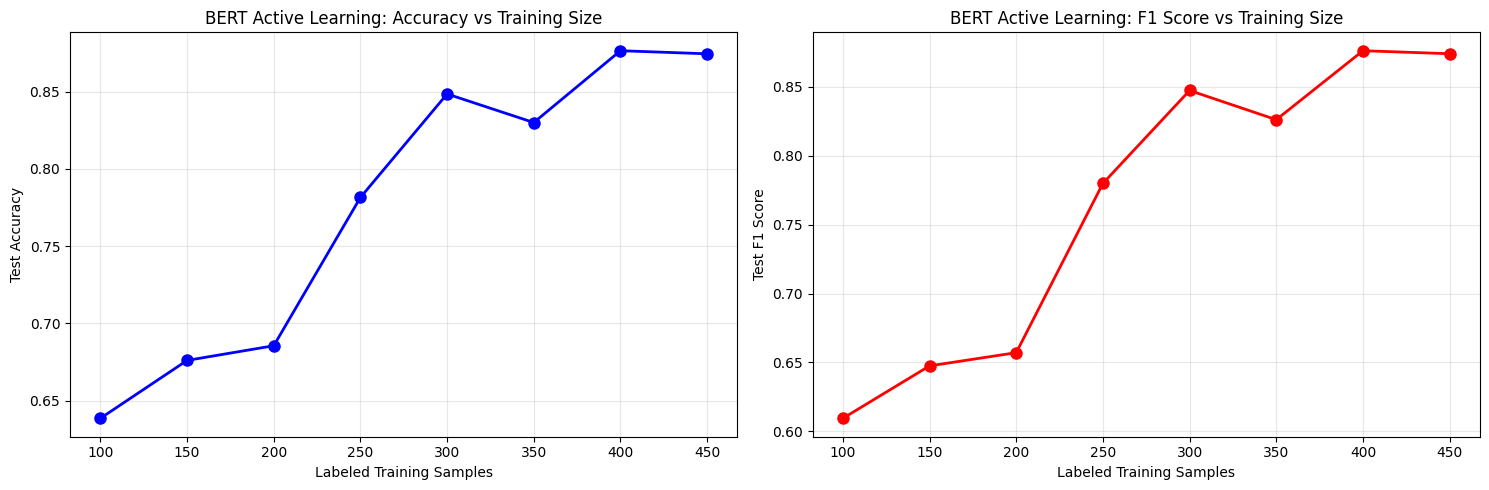

In [18]:
# ====================================================================
# 5. RUN ACTIVE LEARNING EXPERIMENT
# ====================================================================

print("Starting BERT Active Learning Experiment...")
results, final_model = active_learning_pipeline(
    train_texts, train_labels, test_texts, test_labels,
    initial_pool_size=100, query_size=50, max_iterations=8
)

# ====================================================================
# 6. VISUALIZATION AND ANALYSIS
# ====================================================================

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nActive Learning Results:")
print(results_df)

# Plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy curve
ax1.plot(results_df['labeled_size'], results_df['accuracy'], 'b-o', linewidth=2, markersize=8)
ax1.set_xlabel('Labeled Training Samples')
ax1.set_ylabel('Test Accuracy')
ax1.set_title('BERT Active Learning: Accuracy vs Training Size')
ax1.grid(True, alpha=0.3)

# F1 Score curve
ax2.plot(results_df['labeled_size'], results_df['f1_score'], 'r-o', linewidth=2, markersize=8)
ax2.set_xlabel('Labeled Training Samples')
ax2.set_ylabel('Test F1 Score')
ax2.set_title('BERT Active Learning: F1 Score vs Training Size')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# ====================================================================
# 7. COMPARISON WITH RANDOM SAMPLING (BASELINE)
# ====================================================================

def random_sampling_baseline(train_texts, train_labels, test_texts, test_labels,
                           sample_sizes=[100, 200, 300, 400, 500]):
    """
    Random sampling baseline for comparison
    """
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    test_dataset = TextDataset(test_texts, test_labels, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    baseline_results = {'size': [], 'accuracy': [], 'f1_score': []}
    
    for size in sample_sizes:
        print(f"\nTraining with {size} random samples...")
        
        # Random sample
        indices = list(range(len(train_texts)))
        random.shuffle(indices)
        selected_indices = indices[:size]
        
        sample_texts = [train_texts[i] for i in selected_indices]
        sample_labels = [train_labels[i] for i in selected_indices]
        
        # Train model
        model = BERTClassifier().to(device)
        dataset = TextDataset(sample_texts, sample_labels, tokenizer)
        loader = DataLoader(dataset, batch_size=16, shuffle=True)
        
        model = train_model(model, loader, test_loader, epochs=3)
        
        # Evaluate
        accuracy = evaluate_model(model, test_loader)
        
        # Calculate F1
        model.eval()
        predictions, true_labels = [], []
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                logits = model(input_ids, attention_mask)
                preds = torch.argmax(logits, dim=1)
                
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        f1 = f1_score(true_labels, predictions, average='weighted')
        
        baseline_results['size'].append(size)
        baseline_results['accuracy'].append(accuracy)
        baseline_results['f1_score'].append(f1)
        
        print(f"Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return baseline_results

# Run baseline comparison
baseline_results = random_sampling_baseline(
    train_texts, train_labels, test_texts, test_labels,
    sample_sizes=[100, 200, 300, 400, 500]
)


Training with 100 random samples...


Epoch 1/3: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch 1: Loss = 0.6951, Val Acc = 0.4970


Epoch 2/3: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch 2: Loss = 0.5744, Val Acc = 0.7055


Epoch 3/3: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch 3: Loss = 0.4269, Val Acc = 0.6805
Accuracy: 0.7055, F1: 0.7052

Training with 200 random samples...


Epoch 1/3: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


Epoch 1: Loss = 0.6955, Val Acc = 0.5680


Epoch 2/3: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch 2: Loss = 0.6285, Val Acc = 0.8335


Epoch 3/3: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


Epoch 3: Loss = 0.4222, Val Acc = 0.8615
Accuracy: 0.8615, F1: 0.8612

Training with 300 random samples...


Epoch 1/3: 100%|██████████| 19/19 [00:06<00:00,  2.99it/s]


Epoch 1: Loss = 0.6842, Val Acc = 0.5025


Epoch 2/3: 100%|██████████| 19/19 [00:06<00:00,  3.00it/s]


Epoch 2: Loss = 0.5351, Val Acc = 0.8065


Epoch 3/3: 100%|██████████| 19/19 [00:06<00:00,  3.00it/s]


Epoch 3: Loss = 0.3781, Val Acc = 0.7675
Accuracy: 0.8065, F1: 0.8023

Training with 400 random samples...


Epoch 1/3: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Epoch 1: Loss = 0.6823, Val Acc = 0.5190


Epoch 2/3: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Epoch 2: Loss = 0.5552, Val Acc = 0.8450


Epoch 3/3: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Epoch 3: Loss = 0.2687, Val Acc = 0.8790
Accuracy: 0.8790, F1: 0.8789

Training with 500 random samples...


Epoch 1/3: 100%|██████████| 32/32 [00:10<00:00,  3.02it/s]


Epoch 1: Loss = 0.5622, Val Acc = 0.7850


Epoch 2/3: 100%|██████████| 32/32 [00:10<00:00,  3.02it/s]


Epoch 2: Loss = 0.2858, Val Acc = 0.8925


Epoch 3/3: 100%|██████████| 32/32 [00:10<00:00,  3.02it/s]


Epoch 3: Loss = 0.1549, Val Acc = 0.8850
Accuracy: 0.8925, F1: 0.8925


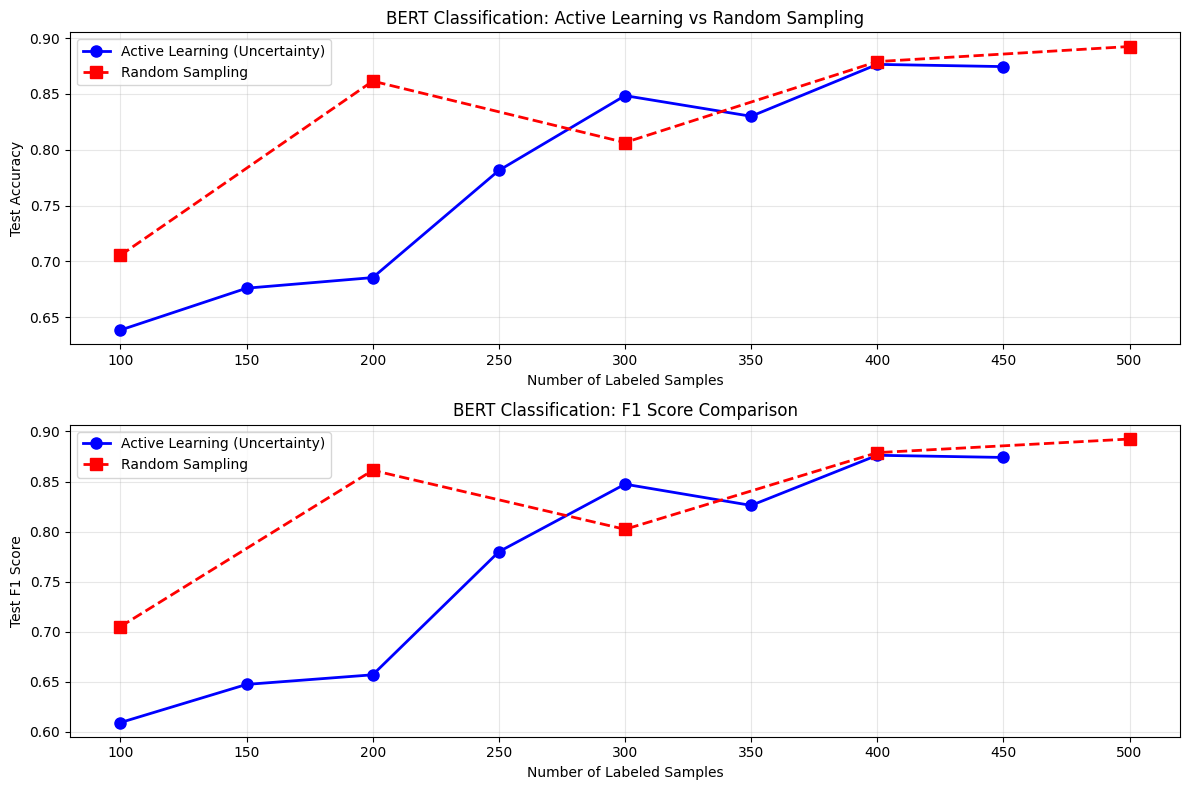

\n============================================================
BERT ACTIVE LEARNING EXPERIMENT COMPLETED!
Final Active Learning Accuracy: 0.8745
Random Sampling Accuracy (500 samples): 0.8925
Sample Efficiency Gain: 2.06%
\nResults saved to CSV files!


In [20]:
# ====================================================================
# 8. FINAL COMPARISON PLOT
# ====================================================================

# Plot comparison
plt.figure(figsize=(12, 8))

# Active Learning curve
plt.subplot(2, 1, 1)
plt.plot(results_df['labeled_size'], results_df['accuracy'], 'b-o', 
         linewidth=2, markersize=8, label='Active Learning (Uncertainty)')
plt.plot(baseline_results['size'], baseline_results['accuracy'], 'r--s', 
         linewidth=2, markersize=8, label='Random Sampling')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Test Accuracy')
plt.title('BERT Classification: Active Learning vs Random Sampling')
plt.legend()
plt.grid(True, alpha=0.3)

# F1 Score comparison
plt.subplot(2, 1, 2)
plt.plot(results_df['labeled_size'], results_df['f1_score'], 'b-o', 
         linewidth=2, markersize=8, label='Active Learning (Uncertainty)')
plt.plot(baseline_results['size'], baseline_results['f1_score'], 'r--s', 
         linewidth=2, markersize=8, label='Random Sampling')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Test F1 Score')
plt.title('BERT Classification: F1 Score Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n" + "="*60)
print("BERT ACTIVE LEARNING EXPERIMENT COMPLETED!")
print("="*60)
print(f"Final Active Learning Accuracy: {results_df['accuracy'].iloc[-1]:.4f}")
print(f"Random Sampling Accuracy (500 samples): {baseline_results['accuracy'][-1]:.4f}")
print(f"Sample Efficiency Gain: {((baseline_results['accuracy'][-1] - results_df['accuracy'].iloc[-1]) / results_df['accuracy'].iloc[-1] * 100):.2f}%")

# Save results
results_df.to_csv('bert_active_learning_results.csv', index=False)
pd.DataFrame(baseline_results).to_csv('bert_random_sampling_results.csv', index=False)
print("\\nResults saved to CSV files!")